<a href="https://colab.research.google.com/github/devansurf/Ocean-MultiClass/blob/main/Ocean_Multiclass_4class_f1-81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ocean Animals Multi-classification model!


In [458]:
#Fetch dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [459]:
!pip install optuna

In [460]:
#Libaries
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import optuna #tuner
import re
import random
import seaborn as sns
from collections import Counter
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch.nn import Module, Conv2d, ConvTranspose2d, Dropout, BatchNorm2d
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms, GaussianBlur

from torch.utils.data import random_split


from PIL import Image

from collections import Counter
from tqdm import tqdm
from IPython.display import display, Math, Latex
from sklearn.utils import resample
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split


In [461]:
#directory
root_dir = '/content/drive/MyDrive/MachineLearning/ocean-dataset'

In [462]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [463]:
#Configuration
class Config:
    #CNN settings
    learning_rate = 2.715011573252679e-05
    #learning_rate = 0.0001
    decay = 0.0001
    num_epochs = 10
    batch_size = 32
    dropout = 0.5 #read online that both batch norm and dropout isnt practical: https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/
    img_dimensions = (152, 152)

    #dataset settings
    num_classifications = 4 #max 23
    target_count = 500

    training_proportion = 0.8
    validation_proportion = 0.1
    test_proportion = 0.1

    #misc
    display_plots = True
    allow_tuner = False

# Helper Functions


In [464]:
def to_numpy(x):
    return x.detach().cpu().numpy()

In [465]:
#Calculate mean std helper:
def calculate_mean_std(dataset):
    dataset_dataloader = DataLoader(
        dataset, batch_size=len(dataset), num_workers=2
    ) # this will allow us to iterate through images in batches
    data = next(iter(dataset_dataloader))
    return data[0].mean(), data[0].std()

In [466]:
def remove_blue_background(image_path, red_threshold = 50, blue_threshold=100):
    # Open the image
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    # Create a mask where the blue channel exceeds the threshold
    blue_mask = (image_np[:, :, 2] > blue_threshold) & \
                (image_np[:, :, 0] < red_threshold)
    # Apply the mask to set those pixels to white (or black)
    #image_np[blue_mask] = [255, 255, 255]  # Set to white
    image_np[blue_mask] = [0, 0, 255]  # Alternatively, set to black

    # Convert back to PIL Image
    return Image.fromarray(image_np)



In [467]:
#Function to undersample to target count
def undersample(image_paths, labels, target_count = 75):
    undersampled_image_paths = []
    undersampled_labels = []

    label_counts = Counter(labels)
    for label in label_counts:
        label_indices = [i for i, lbl in enumerate(labels) if lbl == label]
        if label_counts[label] > target_count:
            undersampled_indices = random.sample(label_indices, k=target_count)
            undersampled_image_paths.extend([image_paths[i] for i in undersampled_indices])
            undersampled_labels.extend([label] * target_count)
        else:
            # Add back all labels
            undersampled_image_paths.extend([image_paths[i] for i in label_indices])
            undersampled_labels.extend([label] * len(label_indices))

    return undersampled_image_paths, undersampled_labels

In [468]:
#Function to balance a subset
def balance(image_paths, labels, target_count=600):
    balanced_image_paths = []
    balanced_labels = []

    label_counts = Counter(labels)
    for label in label_counts:
        label_indices = [i for i, lbl in enumerate(labels) if lbl == label]
        if label_counts[label] > target_count:
            # undersampling
            balanced_indices = random.sample(label_indices, k=target_count)
        else:
            # oversampling
            balanced_indices = random.choices(label_indices, k=target_count)

        balanced_image_paths.extend([image_paths[i] for i in balanced_indices])
        balanced_labels.extend([label] * len(balanced_indices))

    return balanced_image_paths, balanced_labels

In [469]:
def show_random_images(subset, subset_name, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Randomly select an index
        idx = random.randint(0, len(subset) - 1)

        # Get the image and label
        image, label= subset[idx]
        # Convert the tensor image to a NumPy array for visualization
        image_np = image.permute(1, 2, 0).numpy()

        # Subplot for each image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_np)
        plt.title(f'{subset_name} - Label: {label}')
        plt.axis('off')
    plt.show()

In [470]:
def show_distribution(labels, subset_name):
    counts = {}
    for label in labels:
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1

    counts_series = pd.Series(counts)

    # Plot the label counts
    plt.figure(figsize=(15, 5))
    # Plot original counts
    counts_series.plot(kind='bar', color='blue', label='Original')

    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title('Distribution of Labels in: ' + subset_name)
    plt.legend()
    plt.show()

# Custom Dataset Class


In [471]:
class OceanDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):

        assert len(image_paths) == len(labels), "Length mismatch between images and labels"
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.labels[index]

        image = remove_blue_background(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

# CNN

In [472]:
class OceanCNN(nn.Module):
    def __init__(self, dropout=0.5, img_dimensions=(128,128)):
        super(OceanCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        def conv_output_size(size, kernel_size=3, stride=1, padding=1):
            return (size - kernel_size + 2 * padding) // stride + 1

        size = conv_output_size(img_dimensions[0], kernel_size=3) # After first conv layer
        size = size // 2 # After first pooling
        size = conv_output_size(size) # After second conv
        size = size // 2 # After second pooling
        size = conv_output_size(size) # After third conv
        size = size // 2 # After third pooling
        self.final_size = size * size * 128 # Adjusted for 128 filters in the last conv layer


        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(self.final_size, 512)
        self.bn4 = nn.BatchNorm1d(512) # Batch norm for the fully connected layer
        self.fc2 = nn.Linear(512, Config.num_classifications)
        self.dropout = nn.Dropout(dropout)



    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, self.final_size)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Training Function


In [473]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [474]:
def train_model(learning_rate, epochs, dropout, decay, img_dimensions, train_loader, valid_loader):
    torch.manual_seed(69)  # Set seed

    model = OceanCNN(dropout=dropout, img_dimensions=img_dimensions)
    print(model)  # Print model architecture

    if torch.cuda.is_available():
        model = model.to('cuda')  # Move your model to GPU

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)

    acc_hist_train = []
    acc_hist_val = []
    train_losses = []
    val_losses = []

    # Early stopping logic here
    early_stopper = EarlyStopper(patience=10, min_delta=0.1)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        acc_hist_train.append(train_accuracy)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        valid_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()

                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()


        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_accuracy = correct_val / total_val

        if early_stopper.early_stop(valid_loss):
            print(f'Early Stop -> Epoch = {epoch}')
            break

        if (epoch > 1 and valid_loss < np.min(val_losses)) or epoch == 1:
            torch.save(model.state_dict(), 'checkpoint_loss.pt')
            print("Validation loss checkpoint saved!")

        if (epoch > 1 and valid_accuracy > np.max(acc_hist_val)) or epoch == 1:
            torch.save(model.state_dict(), 'checkpoint_acc.pt')
            print("Validation acc checkpoint saved!")


        acc_hist_val.append(valid_accuracy)
        val_losses.append(valid_loss)

        print("valid loss is: ", valid_loss)
        print("minimum of the losses is: ", np.min(val_losses))

        print(f"Epoch: {epoch}")
        print(f"Train Acc: {train_accuracy:.3f}")
        print(f"Val Acc: {valid_accuracy:.3f}")
        print(f"Train Loss: {train_loss:.3f}")
        print(f"Val Loss: {valid_loss:.3f}")
        print("---------------------------------------------")

    model.eval()
    return model, acc_hist_train, acc_hist_val, train_losses, val_losses

# Format Dataset


In [475]:
#Loop through species folders, up to num_classifications
def getData(num_classifications):
    all_image_paths = []
    all_labels = []
    species_folders = sorted(os.listdir(root_dir))[:num_classifications]

    for label, species in enumerate(species_folders):
        species_dir = os.path.join(root_dir, species)
        if os.path.isdir(species_dir):
            for image_name in os.listdir(species_dir):
                image_path = os.path.join(species_dir, image_name)
                if os.path.isfile(image_path):
                    all_image_paths.append(image_path)
                    all_labels.append(label)  # Using index as label

    return all_image_paths, all_labels

#TODO, make sure to split subsets by each classification category, so that training is non-biased (for every species split evenly)
all_image_paths, all_labels = getData(Config.num_classifications)

dataset = OceanDataset(all_image_paths, all_labels, transforms.Compose([ transforms.Resize(Config.img_dimensions), transforms.ToTensor(),]))
mean, std = 0.3758, 0.2585
print('mean: ', mean)
print('std: ', std)
# mean:  tensor(0.3758)
# std:  tensor(0.2585)
#Define transforms (augmentations)
# train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomResizedCrop(Config.img_dimensions[0], scale=(0.9, 1.0)),  # Random zoom,
#     transforms.ToTensor(),
#     transforms.Normalize(mean,std),
# ])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(Config.img_dimensions),

    # Random Resized Crop with a probability
    transforms.RandomApply([transforms.RandomResizedCrop(Config.img_dimensions[0], scale=(0.8, 1.0))], p=0.1),

    # Random Affine with a probability
    #transforms.RandomApply([transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1))], p=0.1),

    # Color Jitter with a probability
    #transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)], p=0.1),

    # Random Rotation with a probability
    #transforms.RandomApply([transforms.RandomRotation(degrees=5)], p=0.1),

    # Gaussian Blur with a probability
    #transforms.RandomApply([transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5))], p=0.1),

    transforms.ToTensor(),
    #transforms.Normalize(mean, std),
])


validation_transform = transforms.Compose([
    transforms.Resize(Config.img_dimensions),
    transforms.ToTensor(),
    #transforms.Normalize(mean,std),
])


def split_dataset(num_classifications, all_image_paths, all_labels):

    # Create empty lists to store split data
    train_paths, validation_paths, test_paths = [], [], []
    train_labels, validation_labels, test_labels = [], [], []

    #This ensures equal representation for each class

    for label in range(num_classifications):

        # Filter paths and labels for the current label
        label_paths = [path for path, l in zip(all_image_paths, all_labels) if l == label]
        label_labels = [l for l in all_labels if l == label]


        #calculate lengths
        total_size = len(label_labels)
        train_size = int(total_size * Config.training_proportion)
        valid_size = int(total_size * Config.validation_proportion)
        test_size = int(total_size * Config.test_proportion)

        # Split into training and temporary set (validation + test)
        paths_train, paths_temp, labels_train, labels_temp = train_test_split(
            label_paths, label_labels, train_size=train_size, random_state=42)

        # Split the temporary set into validation and test sets
        validation_size_adjusted = valid_size / (valid_size + test_size)
        paths_valid, paths_test, labels_valid, labels_test = train_test_split(
            paths_temp, labels_temp, train_size=validation_size_adjusted, random_state=42)

        # Append to main lists
        train_paths.extend(paths_train)
        validation_paths.extend(paths_valid)
        test_paths.extend(paths_test)
        train_labels.extend(labels_train)
        validation_labels.extend(labels_valid)
        test_labels.extend(labels_test)

    return train_paths, train_labels, validation_paths, validation_labels, test_paths, test_labels

#balance dataset first
#all_image_paths, all_labels = balance(all_image_paths, all_labels, Config.target_count)
#call the split dataset function
train_image_paths, train_labels, valid_image_paths, valid_labels, test_image_paths, test_labels = split_dataset(Config.num_classifications, all_image_paths, all_labels)


#Oversample the training subset
balanced_train_image_paths, balanced_train_labels = balance(train_image_paths, train_labels, Config.target_count)

#Undersample other subsets for better visualization
undersampled_valid_image_paths, undersampled_valid_labels = undersample(valid_image_paths, valid_labels, int(Config.target_count*Config.validation_proportion))
undersampled_test_image_paths, undersampled_test_labels = undersample(test_image_paths, test_labels, int(Config.target_count*Config.test_proportion))

#data was split this way in order to apply different transforms across subsets
train_dataset = OceanDataset(balanced_train_image_paths, balanced_train_labels, transform=train_transform)
valid_dataset = OceanDataset(undersampled_valid_image_paths, undersampled_valid_labels, transform=validation_transform)
test_dataset =  OceanDataset(undersampled_test_image_paths, undersampled_test_labels, transform=validation_transform)

#creating data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False)


mean:  0.3758
std:  0.2585


# Visualize formatted dataset

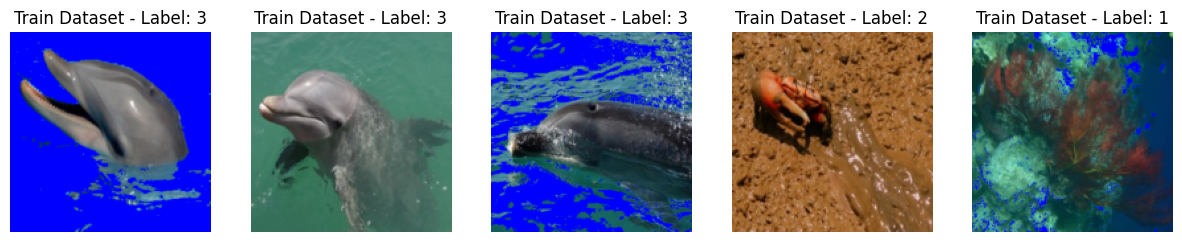

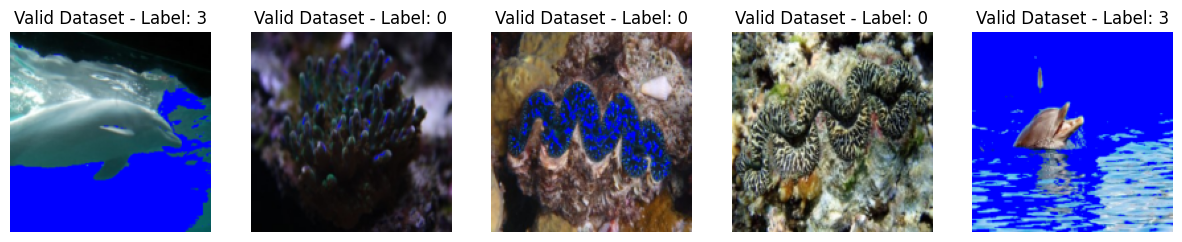

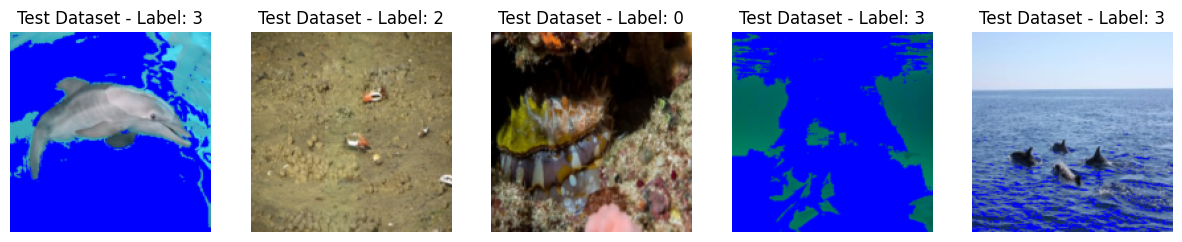

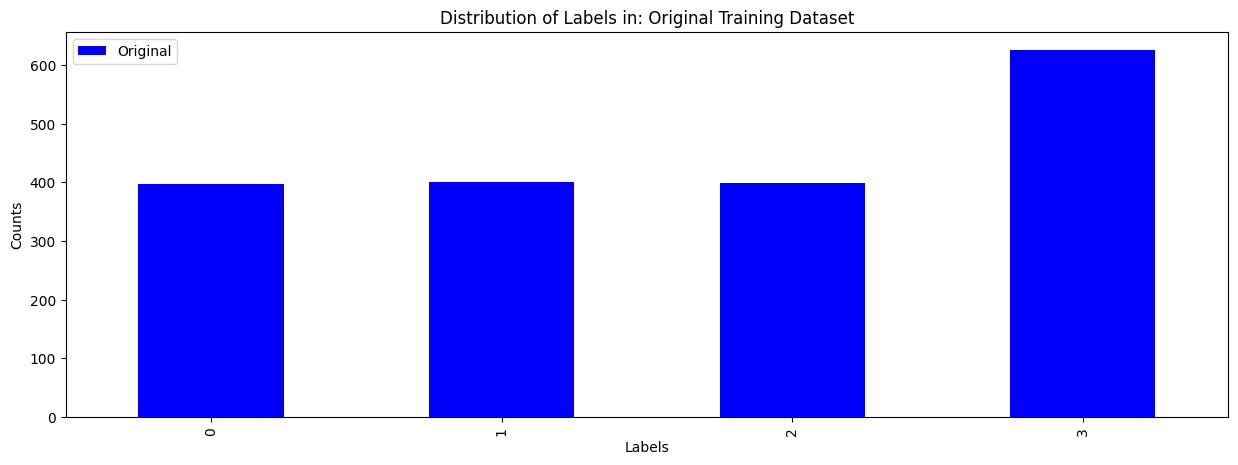

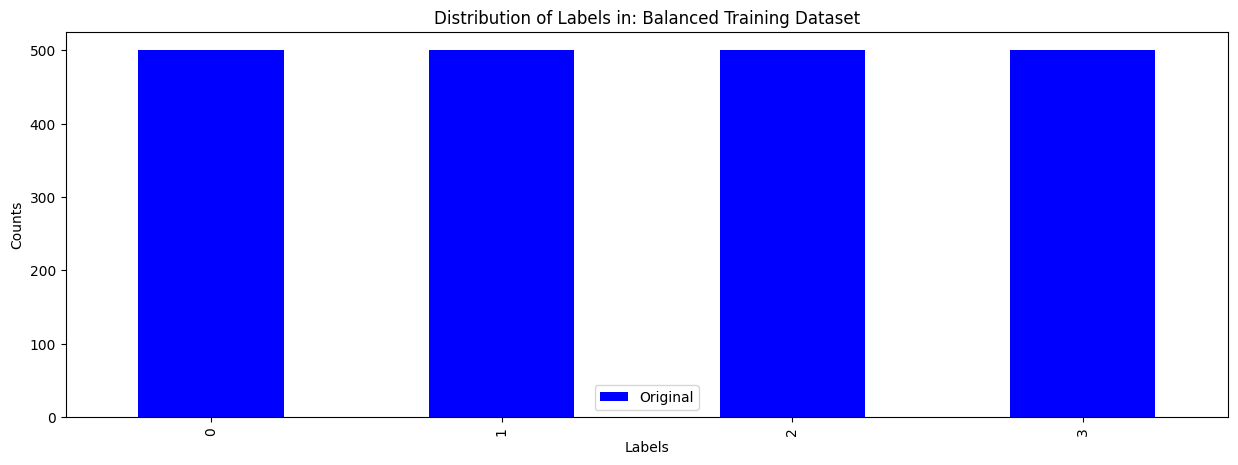

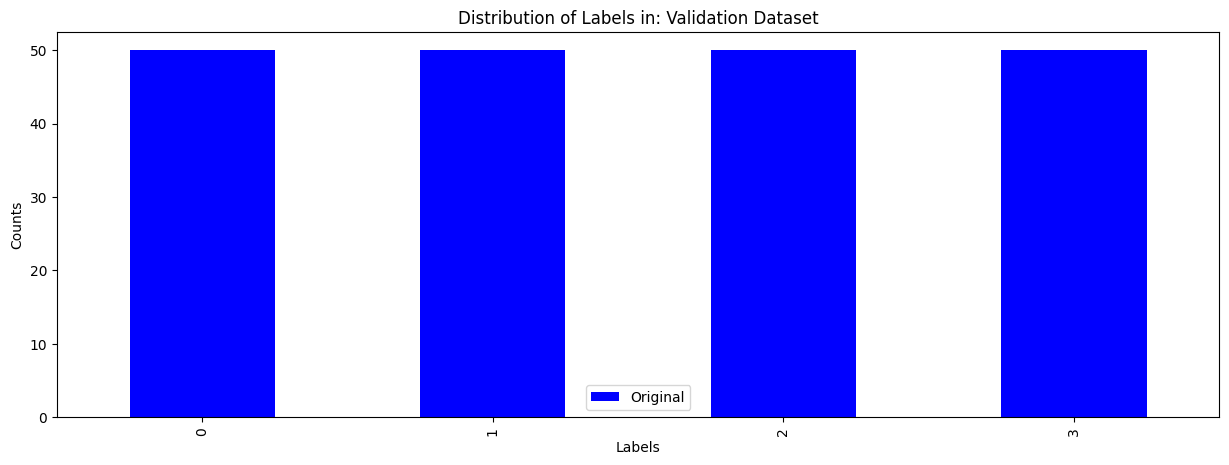

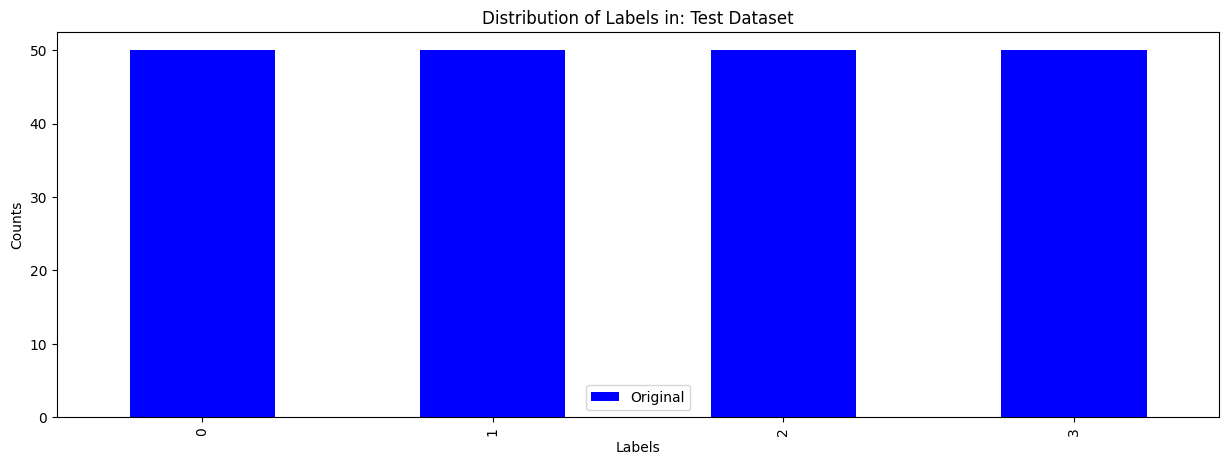

In [476]:
if Config.display_plots:
    show_random_images(train_dataset, "Train Dataset")
    show_random_images(valid_dataset, "Valid Dataset")
    show_random_images(test_dataset, "Test Dataset")

    # Plotting the distribution of the original training dataset
    show_distribution(train_labels, 'Original Training Dataset')

    # Plotting the distribution of the balanced training dataset
    show_distribution(balanced_train_labels, 'Balanced Training Dataset')

    # Plotting the distribution of the validation dataset
    show_distribution(undersampled_valid_labels, 'Validation Dataset')

    # Plotting the distribution of the test dataset
    show_distribution(undersampled_test_labels, 'Test Dataset')

# Training Tuner

In [477]:
#tuner function
def tuner(trial):
    # Define the hyperparameters to be tuned
    learning_rate = trial.suggest_float('learning_rate', 0.00001, 0.0001)
    dropout = Config.dropout#trial.suggest_float('dropout', 0, 0.6)
    img_dimension = Config.img_dimensions[0] #trial.suggest_int('img_dimension', 128, 256, step= 8) #128 to 256 with steps of 8
    batch_size = Config.batch_size#trial.suggest_int('batch_size', 8, 64, step = 8)
    decay = Config.decay
    epochs = 5
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(img_dimension, scale=(0.9, 1.0)),  # Random zoom,
        transforms.ToTensor(),

    ])

    validation_transform = transforms.Compose([
        transforms.Resize((img_dimension, img_dimension)),
        transforms.ToTensor(),
    ])

    #Custom dataset for tuner
    train_dataset = OceanDataset(train_image_paths, train_labels, transform=train_transform)
    valid_dataset = OceanDataset(valid_image_paths, valid_labels, transform=validation_transform)
    test_dataset =  OceanDataset(test_image_paths, test_labels, transform=validation_transform)

    #creating data loaders for each set
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model, acc_hist_train, acc_hist_val, train_losses, val_losses = train_model(learning_rate, epochs, dropout, decay, (img_dimension,img_dimension), train_loader, valid_loader)
    return max(acc_hist_val)

if Config.allow_tuner:
    study = optuna.create_study(direction='maximize')
    study.optimize(tuner, n_trials=30)

    best_params = study.best_params
    print("Best hyperparameters: ", best_params)

# Train the Model


In [478]:
model, acc_hist_train, acc_hist_val, train_losses, val_losses = train_model(Config.learning_rate, Config.num_epochs, Config.dropout, Config.decay, Config.img_dimensions, train_loader, valid_loader)

OceanCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=46208, out_features=512, bias=True)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


100%|██████████| 63/63 [00:22<00:00,  2.81it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  0.7617066502571106
minimum of the losses is:  0.7617066502571106
Epoch: 1
Train Acc: 0.711
Val Acc: 0.700
Train Loss: 0.754
Val Loss: 0.762
---------------------------------------------


100%|██████████| 63/63 [00:15<00:00,  3.97it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  0.6689718198776246
minimum of the losses is:  0.6689718198776246
Epoch: 2
Train Acc: 0.837
Val Acc: 0.730
Train Loss: 0.470
Val Loss: 0.669
---------------------------------------------


100%|██████████| 63/63 [00:13<00:00,  4.63it/s]


valid loss is:  0.7392501890659332
minimum of the losses is:  0.6689718198776246
Epoch: 3
Train Acc: 0.892
Val Acc: 0.720
Train Loss: 0.346
Val Loss: 0.739
---------------------------------------------


100%|██████████| 63/63 [00:13<00:00,  4.60it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  0.6347964203357697
minimum of the losses is:  0.6347964203357697
Epoch: 4
Train Acc: 0.916
Val Acc: 0.745
Train Loss: 0.284
Val Loss: 0.635
---------------------------------------------


100%|██████████| 63/63 [00:13<00:00,  4.60it/s]


Validation acc checkpoint saved!
valid loss is:  0.6420163607597351
minimum of the losses is:  0.6347964203357697
Epoch: 5
Train Acc: 0.935
Val Acc: 0.750
Train Loss: 0.236
Val Loss: 0.642
---------------------------------------------


100%|██████████| 63/63 [00:13<00:00,  4.56it/s]


valid loss is:  0.645600700378418
minimum of the losses is:  0.6347964203357697
Epoch: 6
Train Acc: 0.960
Val Acc: 0.750
Train Loss: 0.172
Val Loss: 0.646
---------------------------------------------


100%|██████████| 63/63 [00:13<00:00,  4.65it/s]


Validation acc checkpoint saved!
valid loss is:  0.643877910375595
minimum of the losses is:  0.6347964203357697
Epoch: 7
Train Acc: 0.959
Val Acc: 0.755
Train Loss: 0.173
Val Loss: 0.644
---------------------------------------------


100%|██████████| 63/63 [00:14<00:00,  4.36it/s]


valid loss is:  0.6783292543888092
minimum of the losses is:  0.6347964203357697
Epoch: 8
Train Acc: 0.972
Val Acc: 0.740
Train Loss: 0.132
Val Loss: 0.678
---------------------------------------------


100%|██████████| 63/63 [00:14<00:00,  4.36it/s]


valid loss is:  0.6879081702232361
minimum of the losses is:  0.6347964203357697
Epoch: 9
Train Acc: 0.978
Val Acc: 0.735
Train Loss: 0.117
Val Loss: 0.688
---------------------------------------------


100%|██████████| 63/63 [00:13<00:00,  4.67it/s]


Validation acc checkpoint saved!
valid loss is:  0.6396676695346832
minimum of the losses is:  0.6347964203357697
Epoch: 10
Train Acc: 0.983
Val Acc: 0.760
Train Loss: 0.102
Val Loss: 0.640
---------------------------------------------


# Evaluation


In [479]:
load_acc_checkpoint = False
if load_acc_checkpoint:
    model = OceanCNN(dropout=Config.dropout, img_dimensions=Config.img_dimensions)
    model.load_state_dict(torch.load('checkpoint_acc.pt'))
    if torch.cuda.is_available():
        model = model.to('cuda')  # Move your model to GPU


In [480]:
#Load loss checkpoint if requested
load_loss_checkpoint = False
if load_loss_checkpoint:
    model = OceanCNN(dropout=Config.dropout, img_dimensions=Config.img_dimensions)
    model.load_state_dict(torch.load('checkpoint_loss.pt'))
    if torch.cuda.is_available():
        model = model.to('cuda')  # Move your model to GPU

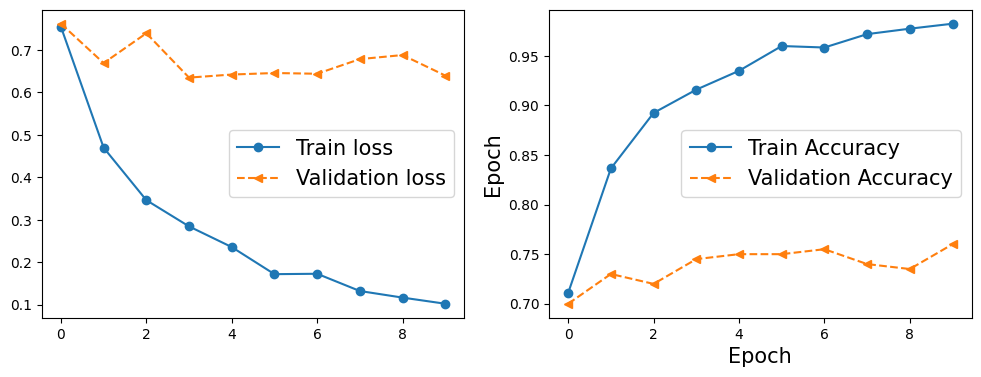

In [481]:
#Plot graphs

loss_axis = list(range(len(train_losses)))
val_axis = list(range(len(val_losses)))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)

ax.plot(loss_axis, train_losses, '-o', label = 'Train loss')
ax.plot(val_axis , val_losses, '--<', label = 'Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(loss_axis, acc_hist_train, '-o', label='Train Accuracy')
ax.plot(val_axis, acc_hist_val, '--<', label='Validation Accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Epoch', size=15)
plt.show()

In [482]:
accuracy_test = 0.0
actual_labels = []
predicted_labels = []
with torch.no_grad():
    # disables gradient calculation
    for x, y in test_loader:
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
        pred = model(x)  # predict
        is_correct = (torch.argmax(pred, dim=1) == y).sum().float()
        accuracy_test += is_correct
        actual_labels.append(to_numpy(y))
        predicted_labels.append(to_numpy(torch.argmax(pred, dim=1)))

    # Divide the sum of correct predictions by the total number of samples, not the length of the dataset
    accuracy_test /= len(test_loader.dataset)

print(f'test accuracy: {accuracy_test}')
print(f"{bcolors.OKCYAN}{bcolors.BOLD}NOTE: Test Accuracy above is provided for reference only. It can be a misleading statistic for imbalanced data.")
predicted_labels = [item for sublist in predicted_labels for item in sublist]
actual_labels = [item for sublist in actual_labels for item in sublist]
F1_score = f1_score(actual_labels, predicted_labels, average='macro')
print(f'f1_score: {F1_score}')

test accuracy: 0.8149999976158142
NOTE: Test Accuracy above is provided for reference only. It can be a misleading statistic for imbalanced data.
f1_score: 0.8103671853671854


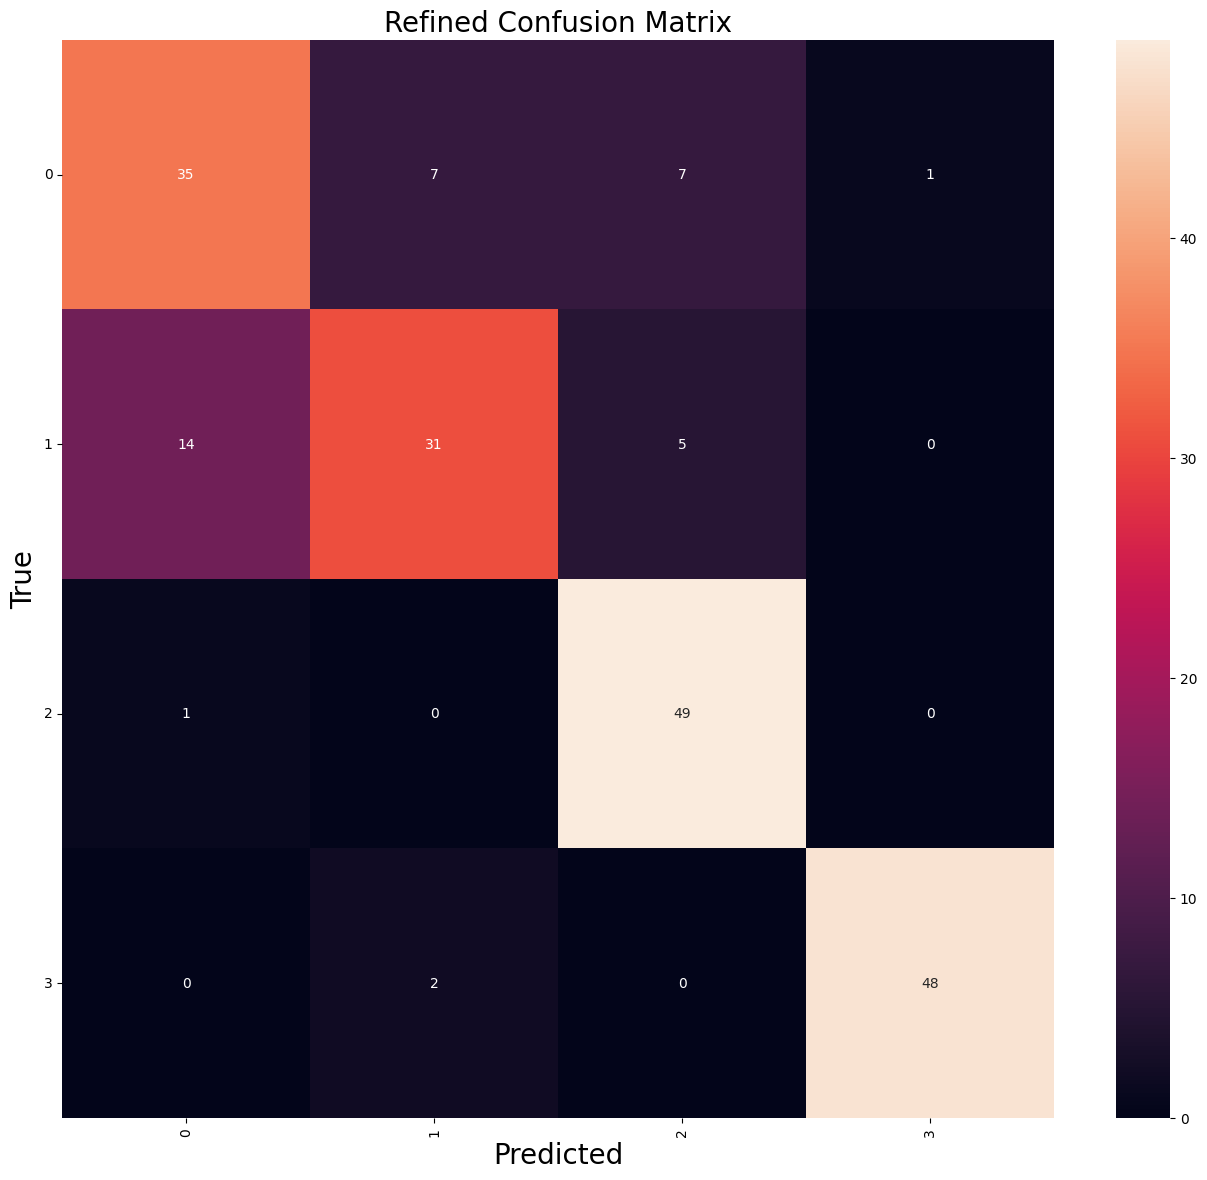

f1_score: 0.8103671853671854


In [483]:
cm = confusion_matrix(actual_labels, predicted_labels)

labels = dataset.labels

fig = plt.figure(figsize=(16, 14))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt="g")
ax.set_xlabel("Predicted", fontsize=20)
ax.xaxis.set_label_position("bottom")
plt.xticks(rotation=90)
ax.xaxis.tick_bottom()

ax.set_ylabel("True", fontsize=20)
plt.yticks(rotation=0)

plt.title("Refined Confusion Matrix", fontsize=20)

plt.show()

F1_score = f1_score(actual_labels, predicted_labels, average='macro')

print(f'f1_score: {F1_score}')